In [1]:
from os.path import join
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from growth.sweep.sweep import Sweep
from clones.visualization.settings import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from clones.annotation.spatial import WeightedGraph
from clones.annotation.spatial.sampling import CommunitySampler, NeighborSampler
from clones.annotation.annotation import Annotation

In [3]:
def score(x, y):
    """ Returns fraction of labels that are the same. """
    return (x==y).sum()/x.size

In [4]:
# from clones.data.experiments import Experiment

# stack_id = 4
# layer_id = 0

# # load experiment
# experiment = Experiment('../../../data/drosophila/')

# # load image stack
# stack = experiment.load_stack(experiment.stack_ids[stack_id], full=True)
# layer = stack[layer_id]

# Generate synthetic data

Load simulated bleedthrough control experiment and generate synthetic fluorescence data. Synthetic images contain three color channels:
   - BLUE: Nuclear stain
   - RED: Clonal marker
   - GREEN: Control reporter

In [4]:
ambiguity = .6

sweep = Sweep.load('../../../data/synthetic/sweeps/Sweep_181201_191516/')
simulation = sweep[129]

measurement_kwargs = dict(measurement_noise=0.)
microscopy_kwargs = dict(bg_level=0.2, bg_noise=0.3)

microscopy = simulation.generate_microscopy(ambiguity=ambiguity, rho=0.0, bleedthrough=0.5, 
                measurement_kwargs=measurement_kwargs, microscopy_kwargs=microscopy_kwargs)

data = microscopy.data

In [5]:
attr = 'clonal_marker'
graph = WeightedGraph(data, attr)

# ground truth
ground_truth = graph.df.true_dosage.values

def plot(ax, labels, label):
    ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=labels, s=2)
    ax.set_title('{:s}\n{:0.2%}'.format(label, score(ground_truth, labels)))
    ax.axis('off')
    ax.set_aspect(1)

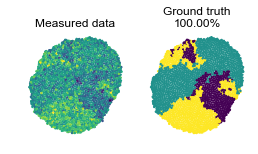

In [6]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(4,2))

ax0.scatter(graph.df.centroid_x, graph.df.centroid_y, c=np.log(graph.df.clonal_marker), s=2)
ax0.set_title('Measured data')
ax0.axis('off')
ax0.set_aspect(1)

plot(ax1, ground_truth, 'Ground truth')

### Train classifier

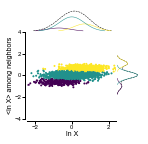

In [8]:
#neighborhood sampler
kw = dict(depth=2)
annotator = Annotation('clonal_marker', sampler_type='neighbors', sampler_kwargs=kw, max_num_components=3)

# # community sampler
# kw = dict(twolevel=False, depth=2)
# annotator = Annotation('clonal_marker', sampler_type='community', sampler_kwargs=kw, min_num_components=3, max_num_components=3)

# radial sampler
#kw = dict(depth=1.)
#annotator = Annotation('clonal_marker', sampler_type='radial', sampler_kwargs=kw, max_num_components=3)

selector = annotator.train(graph)
_ = annotator.classifier.plot_bivariate_data(s=1)

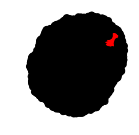

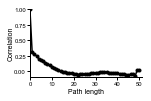

In [9]:
sampler = annotator.get_sampler(graph)
sampler.plot_neigborhood(40)

### Assign labels

In [66]:
marginal_labels = annotator.annotate(graph, sampler_type=None, threshold=1.)
neighborhood_labels = annotator.annotate(graph, sampler_type='neighbors', sampler_kwargs=dict(depth=2))
twolevel_community_labels = annotator.annotate(graph, sampler_type='community', sampler_kwargs=dict(twolevel=True))
multilevel_community_labels = annotator.annotate(graph, sampler_type='community', sampler_kwargs=dict(depth=1))
radial_labels = annotator.annotate(graph, sampler_type='radial', sampler_kwargs=dict(depth=1.))

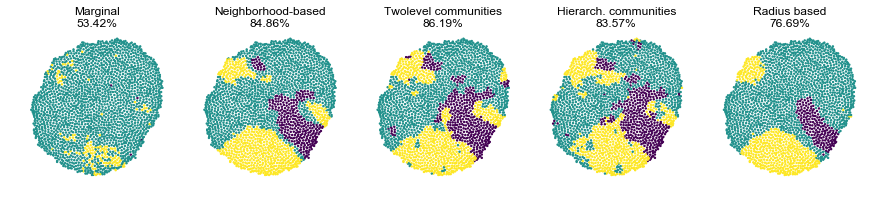

In [67]:
ncols = 5
fig, axes = plt.subplots(ncols=ncols, figsize=(ncols*3,3))

plot(axes[0], marginal_labels, 'Marginal')
plot(axes[1], neighborhood_labels, 'Neighborhood-based')
plot(axes[2], twolevel_community_labels, 'Twolevel communities')
plot(axes[3], multilevel_community_labels, 'Hierarch. communities')
plot(axes[4], radial_labels, 'Radius based')

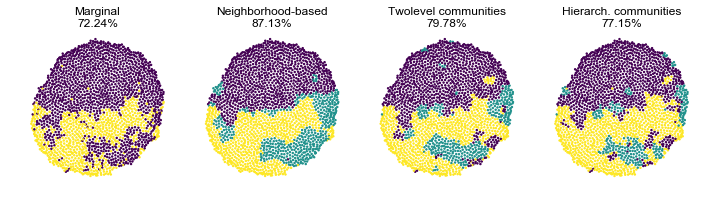

In [57]:
ncols = 4
fig, axes = plt.subplots(ncols=ncols, figsize=(ncols*3,3))

plot(axes[0], marginal_labels, 'Marginal')
plot(axes[1], neighborhood_labels, 'Neighborhood-based')
plot(axes[2], twolevel_community_labels, 'Twolevel communities')
plot(axes[3], multilevel_community_labels, 'Hierarch. communities')

In [ ]:
correlation = graph.get_correlations('clonal_marker')
#correlation.histogram_distances(bins=100)
#correlation.histogram_fluctuations(bins=100)
correlation.visualize(window_size=500, max_distance=300)

from clones.annotation.spatial.correlation import CharacteristicLength
char = CharacteristicLength(correlation)
char.plot_fit(ax=plt.gca(), color='r', linestyle='--')

# graph correlation

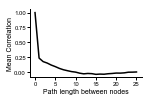

In [245]:
from clones.annotation.spatial.sampling import CommunitySampler
sampler = CommunitySampler(graph, 'clonal_marker')
sampler.plot_autocorrelation()